# Interactive Sector and Trajectory Visualization

This notebook provides an interactive interface to:
1. Select a reference sector from the flows CSV data
2. Visualize all trajectories of flights passing through that reference sector
3. Display the reference sector
4. Manually specify and display a hotspot sector

**Data Source:** `output/examples/basic_run/flows_with_cache.csv`

In [22]:
import json
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, LineString
import sys
import os
from ipywidgets import interact, widgets, HBox, VBox
from IPython.display import display, clear_output

# Add the project source to path for imports
sys.path.append('../src')
from project_tailwind.impact_eval.tvtw_indexer import TVTWIndexer

plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

## Load Data

In [23]:
# Load flow groups data from CSV
flows_df = pd.read_csv('../output/examples/basic_run/flows_with_cache.csv')

# Convert CSV data to similar structure as original flow_groups
flow_groups = []
for _, row in flows_df.iterrows():
    # Parse flight IDs from space-separated string
    flight_ids = str(row['flight_ids']).split() if pd.notna(row['flight_ids']) else []
    
    flow_group = {
        'reference_sector': row['reference_sector'],
        'group_flights': flight_ids,
        'score': row['score'],
        'avg_pairwise_similarity': row['avg_pairwise_similarity'],
        'group_size': row['group_size'],
        'hotspot_traffic_volume_id': row['hotspot_traffic_volume_id'],
        'hotspot_hour': row['hotspot_hour']
    }
    flow_groups.append(flow_group)

# Load traffic volumes
traffic_volumes = gpd.read_file('D:/project-cirrus/cases/traffic_volumes_with_capacity.geojson')

# Load CSV trajectory data
trajectory_df = pd.read_csv('D:/project-cirrus/cases/flights_20230801.csv')

print(f"Loaded {len(flow_groups)} flow groups from CSV")
print(f"Loaded {len(traffic_volumes)} traffic volumes")
print(f"Loaded {len(trajectory_df)} trajectory segments")

# Get unique reference sectors for dropdown
reference_sectors = sorted(list(set([group['reference_sector'] for group in flow_groups if pd.notna(group['reference_sector'])])))
print(f"\nFound {len(reference_sectors)} unique reference sectors")

Skipping field elementary_sectors: unsupported OGR type: 5


Loaded 203 flow groups from CSV
Loaded 1612 traffic volumes
Loaded 1214748 trajectory segments

Found 148 unique reference sectors


## Utility Functions

In [24]:
def get_flight_trajectory(flight_id, trajectory_df):
    """
    Extract flight trajectory from CSV data
    """
    if isinstance(flight_id, str):
        flight_id = int(flight_id)
    flight_segments = trajectory_df[trajectory_df['flight_identifier'] == flight_id].copy()
    
    if flight_segments.empty:
        return None
    
    # Sort by sequence
    flight_segments = flight_segments.sort_values('sequence')
    
    # Create trajectory coordinates
    coordinates = []
    first_segment = flight_segments.iloc[0]
    coordinates.append((first_segment['longitude_begin'], first_segment['latitude_begin']))
    
    for _, segment in flight_segments.iterrows():
        coordinates.append((segment['longitude_end'], segment['latitude_end']))
    
    # Create trajectory geometry
    trajectory_geom = LineString(coordinates)
    
    # Get flight metadata
    flight_info = {
        'flight_identifier': flight_id,
        'call_sign': first_segment['call_sign'],
        'origin': first_segment['origin_aerodrome'],
        'destination': first_segment['destination_aerodrome'],
        'geometry': trajectory_geom,
        'num_segments': len(flight_segments)
    }
    
    return flight_info

def get_sector_geometry(sector_id, traffic_volumes):
    """
    Get geometry for a specific sector/traffic volume
    """
    sector_data = traffic_volumes[traffic_volumes['traffic_volume_id'] == sector_id]
    if sector_data.empty:
        return None
    return sector_data.iloc[0]

def get_flows_for_reference_sector(reference_sector, flow_groups):
    """
    Get all flow groups for a specific reference sector
    """
    matching_flows = [group for group in flow_groups if group['reference_sector'] == reference_sector]
    return matching_flows

def get_specific_flow(reference_sector, hotspot_sector, flow_groups):
    """
    Get the specific flow group that matches both reference sector and hotspot
    """
    for group in flow_groups:
        if (group['reference_sector'] == reference_sector and 
            group['hotspot_traffic_volume_id'] == hotspot_sector):
            return group
    return None

## Visualization Function

In [25]:
def plot_sector_trajectories(reference_sector, hotspot_sector, traffic_volumes, trajectory_df, flow_groups):
    """
    Plot trajectories for flights in the specific reference-hotspot flow group,
    along with the reference sector and hotspot sector
    """
    # Get the specific flow group that matches both reference sector and hotspot
    matching_flow = get_specific_flow(reference_sector, hotspot_sector, flow_groups)
    
    if not matching_flow:
        print(f"❌ No flow found for reference sector '{reference_sector}' and hotspot '{hotspot_sector}'")
        return
    
    # Get flight IDs from the specific flow group
    flight_ids = matching_flow['group_flights']
    
    print(f"\n🔍 Analysis for Flow Group:")
    print(f"   📍 Reference Sector: {reference_sector}")
    print(f"   🔥 Hotspot Sector: {hotspot_sector}")
    print(f"   ✈️  Flights in this group: {len(flight_ids)}")
    print(f"   📊 Score: {matching_flow['score']:.3f}")
    print(f"   🔗 Avg Similarity: {matching_flow['avg_pairwise_similarity']:.3f}")
    
    # Get trajectories for all flights in this specific flow group
    trajectories = []
    for flight_id in flight_ids:
        traj = get_flight_trajectory(flight_id, trajectory_df)
        if traj:
            trajectories.append(traj)
    
    print(f"   📍 Successfully loaded {len(trajectories)} trajectories")
    
    # Get sector geometries
    reference_sector_geom = get_sector_geometry(reference_sector, traffic_volumes)
    hotspot_sector_geom = get_sector_geometry(hotspot_sector, traffic_volumes) if hotspot_sector else None
    
    if reference_sector_geom is None:
        print(f"⚠️  Warning: Reference sector '{reference_sector}' not found in traffic volumes")
    
    if hotspot_sector and hotspot_sector_geom is None:
        print(f"⚠️  Warning: Hotspot sector '{hotspot_sector}' not found in traffic volumes")
    
    # Create the plot
    fig = plt.figure(figsize=(18, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Calculate bounds from trajectories and sectors
    all_bounds = []
    
    # Add trajectory bounds
    for traj in trajectories:
        all_bounds.append(traj['geometry'].bounds)
    
    # Add sector bounds
    if reference_sector_geom is not None:
        all_bounds.append(reference_sector_geom.geometry.bounds)
    if hotspot_sector_geom is not None:
        all_bounds.append(hotspot_sector_geom.geometry.bounds)
    
    if all_bounds:
        min_lon = min([b[0] for b in all_bounds]) - 1
        min_lat = min([b[1] for b in all_bounds]) - 1
        max_lon = max([b[2] for b in all_bounds]) + 1
        max_lat = max([b[3] for b in all_bounds]) + 1
    else:
        # Default extent if no data
        min_lon, max_lon, min_lat, max_lat = -10, 10, 40, 60
    
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
    ax.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    
    # Plot reference sector
    if reference_sector_geom is not None:
        ax.add_geometries([reference_sector_geom.geometry], ccrs.PlateCarree(),
                         facecolor='yellow', edgecolor='orange',
                         alpha=0.7, linewidth=3)
        
        # Add reference sector label
        centroid = reference_sector_geom.geometry.centroid
        ax.text(centroid.x, centroid.y, f"REF: {reference_sector}",
                transform=ccrs.PlateCarree(), ha='center', va='center',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.9))
    
    # Plot hotspot sector
    if hotspot_sector_geom is not None:
        ax.add_geometries([hotspot_sector_geom.geometry], ccrs.PlateCarree(),
                         facecolor='red', edgecolor='darkred',
                         alpha=0.7, linewidth=3)
        
        # Add hotspot sector label
        centroid = hotspot_sector_geom.geometry.centroid
        ax.text(centroid.x, centroid.y, f"HOTSPOT: {hotspot_sector}",
                transform=ccrs.PlateCarree(), ha='center', va='center',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.9, edgecolor='white'))
    
    # Plot flight trajectories
    colors = plt.cm.tab10(np.linspace(0, 1, len(trajectories)))
    
    for i, traj in enumerate(trajectories):
        trajectory_coords = list(traj['geometry'].coords)
        lons, lats = zip(*trajectory_coords)
        
        # Plot trajectory
        ax.plot(lons, lats, 
                color=colors[i], linewidth=2, alpha=0.8,
                transform=ccrs.PlateCarree())
        
        # Mark start and end points
        ax.plot(lons[0], lats[0], 'o', color=colors[i], markersize=6, 
                transform=ccrs.PlateCarree(), alpha=0.9)
        ax.plot(lons[-1], lats[-1], 's', color=colors[i], markersize=6, 
                transform=ccrs.PlateCarree(), alpha=0.9)
        
        # Add flight label at midpoint
        mid_idx = len(trajectory_coords) // 2
        mid_lon, mid_lat = trajectory_coords[mid_idx]
        ax.text(mid_lon, mid_lat, f"{traj['call_sign']}",
                transform=ccrs.PlateCarree(), ha='center', va='center',
                fontsize=7, color=colors[i], fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.8))
    
    # Create title
    title_parts = [
        f'Flow Group: {reference_sector} → {hotspot_sector}',
        f'Trajectories: {len(trajectories)} flights (Score: {matching_flow["score"]:.2f})'
    ]
    
    plt.title('\n'.join(title_parts), fontsize=14, fontweight='bold')
    
    # Custom legend
    legend_elements = []
    if reference_sector_geom is not None:
        legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='yellow', alpha=0.7, label='Reference Sector'))
    if hotspot_sector_geom is not None:
        legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.7, label='Hotspot Sector'))
    legend_elements.extend([
        plt.Line2D([0], [0], color='gray', linewidth=2, label='Flight Trajectories'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, label='Start'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=6, label='End')
    ])
    
    if legend_elements:
        plt.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print flow group details
    print(f"\n📊 Flow Group Details:")
    print("=" * 80)
    print(f"Reference Sector: {reference_sector}")
    print(f"Hotspot Sector: {hotspot_sector}")
    print(f"Number of Flights: {len(flight_ids)}")
    print(f"Score: {matching_flow['score']:.3f}")
    print(f"Avg Pairwise Similarity: {matching_flow['avg_pairwise_similarity']:.3f}")
    print(f"Flight IDs: {', '.join(flight_ids)}")
    print()

## Interactive Interface

In [ ]:
# Create reference-hotspot pair options from CSV data
pair_options = []
pair_labels = []

for _, row in flows_df.iterrows():
    ref_sector = row['reference_sector']
    hotspot = row['hotspot_traffic_volume_id']
    
    # Create display label and value tuple
    if pd.notna(hotspot):
        label = f"{ref_sector} → {hotspot}"
        value = (ref_sector, hotspot)
    else:
        label = f"{ref_sector} → (no hotspot)"
        value = (ref_sector, None)
    
    pair_labels.append(label)
    pair_options.append(value)

# Create dropdown with reference-hotspot pairs
pair_dropdown = widgets.Dropdown(
    options=[(label, value) for label, value in zip(pair_labels, pair_options)],
    value=pair_options[0] if pair_options else None,
    description='Reference → Hotspot:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

print(f"Available reference-hotspot pairs: {len(pair_options)}")
print(f"Sample pairs:")
for i, label in enumerate(pair_labels[:5]):
    print(f"  {i+1}. {label}")
if len(pair_labels) > 5:
    print(f"  ... and {len(pair_labels)-5} more")

# Create output widget for the plot
output = widgets.Output()

def update_plot(selected_pair):
    with output:
        clear_output(wait=True)
        if selected_pair:
            reference_sector, hotspot_sector = selected_pair
            plot_sector_trajectories(
                reference_sector, 
                hotspot_sector,
                traffic_volumes, 
                trajectory_df, 
                flow_groups
            )
        else:
            print("Please select a reference-hotspot pair.")

# Link widget to update function
interactive_plot = widgets.interactive(
    update_plot,
    selected_pair=pair_dropdown
)

# Display the interface
display(VBox([pair_dropdown, output]))

# Initial plot
if pair_options:
    update_plot(pair_options[0])

Available reference-hotspot pairs: 203
Sample pairs:
  1. EDUSN → EDG6PAD
  2. EDUD234 → EDG6PAD
  3. EDUAPR → EDG6PAD
  4. EDUEAST → EDG6PAD
  5. EDUD3C → EDG6PAD
  ... and 198 more


## Manual Plotting (Alternative Interface)

If the interactive widgets don't work properly, you can use this cell to manually specify the sectors:

Available reference-hotspot pairs (showing first 10):
→ 0: EDUSN → EDG6PAD
  1: EDUD234 → EDG6PAD
  2: EDUAPR → EDG6PAD
  3: EDUEAST → EDG6PAD
  4: EDUD3C → EDG6PAD
  5: EDUERL1R → EDG6PAD
  6: EDUD1C → EDG6PAD
  7: EDUERL12 → EDG6PAD
  8: EDWSUEDC → EDG6PAD
  9: EDUD2C → EDG6PAD

Plotting for pair 0:
  Reference sector: EDUSN
  Hotspot sector: EDG6PAD

🔍 Analysis for Flow Group:
   📍 Reference Sector: EDUSN
   🔥 Hotspot Sector: EDG6PAD
   ✈️  Flights in this group: 12
   📊 Score: 49.536
   🔗 Avg Similarity: 0.487
   📍 Successfully loaded 12 trajectories


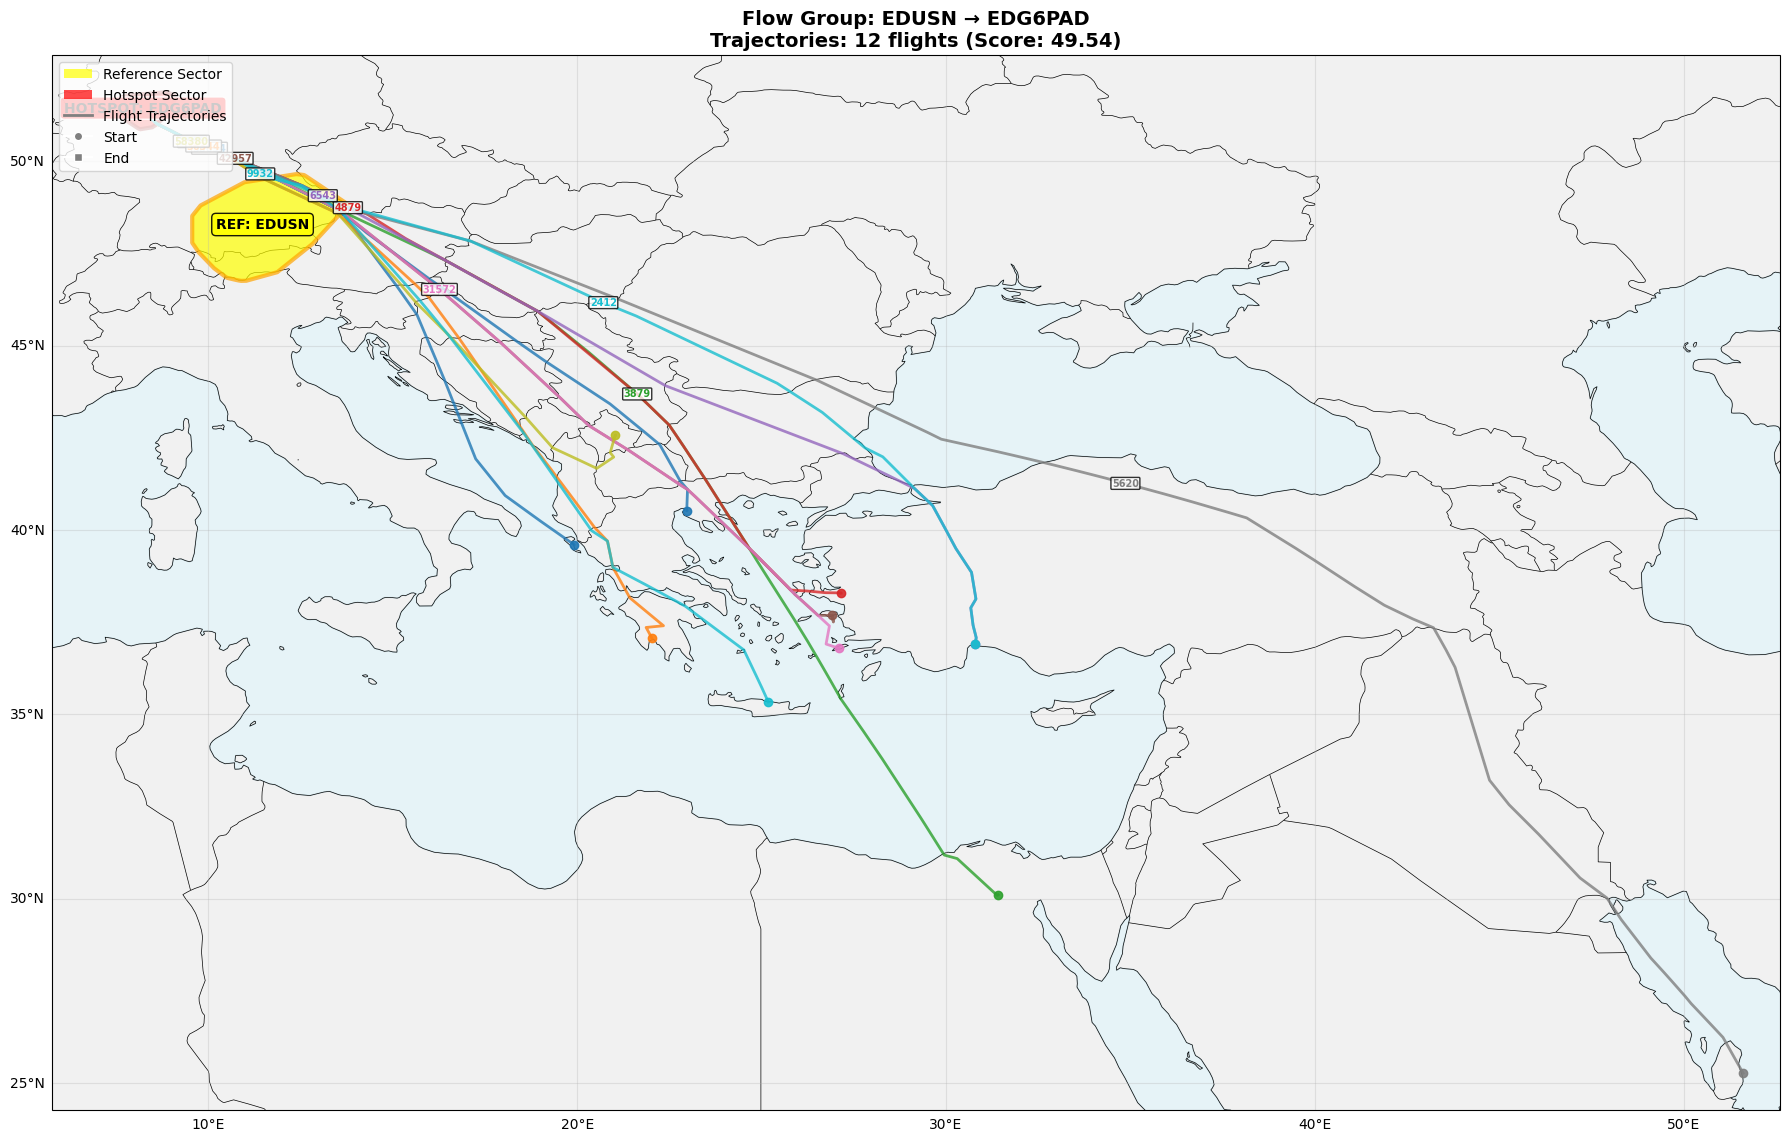


📊 Flow Group Details:
Reference Sector: EDUSN
Hotspot Sector: EDG6PAD
Number of Flights: 12
Score: 49.536
Avg Pairwise Similarity: 0.487
Flight IDs: 263867790, 263868188, 263867187, 263864498, 263866963, 263866793, 263866132, 263865979, 263861105, 263867387, 263865926, 263866383



In [27]:
# Manual configuration - change these values as needed
# Select a specific row from the CSV for manual plotting
SELECTED_ROW = 0  # Change this index to select different reference-hotspot pairs

if len(flows_df) > SELECTED_ROW:
    selected_row = flows_df.iloc[SELECTED_ROW]
    REFERENCE_SECTOR = selected_row['reference_sector']
    HOTSPOT_SECTOR = selected_row['hotspot_traffic_volume_id']
    
    print(f"Available reference-hotspot pairs (showing first 10):")
    for i, (_, row) in enumerate(flows_df.head(10).iterrows()):
        marker = "→" if i == SELECTED_ROW else " "
        hotspot = row['hotspot_traffic_volume_id'] if pd.notna(row['hotspot_traffic_volume_id']) else "(no hotspot)"
        print(f"{marker} {i}: {row['reference_sector']} → {hotspot}")
    
    print(f"\nPlotting for pair {SELECTED_ROW}:")
    print(f"  Reference sector: {REFERENCE_SECTOR}")
    print(f"  Hotspot sector: {HOTSPOT_SECTOR}")
    
    plot_sector_trajectories(
        REFERENCE_SECTOR, 
        HOTSPOT_SECTOR,
        traffic_volumes, 
        trajectory_df, 
        flow_groups
    )
else:
    print("No data available for manual plotting")

## Reference Sector Information

Use this cell to explore all available reference sectors and their flow group counts:

In [28]:
# Analyze reference sectors
sector_stats = {}
for group in flow_groups:
    sector = group['reference_sector']
    if sector not in sector_stats:
        sector_stats[sector] = {
            'flow_groups': 0,
            'total_flights': set(),
            'max_score': 0,
            'avg_score': []
        }
    
    sector_stats[sector]['flow_groups'] += 1
    sector_stats[sector]['total_flights'].update(group['group_flights'])
    sector_stats[sector]['max_score'] = max(sector_stats[sector]['max_score'], group['score'])
    sector_stats[sector]['avg_score'].append(group['score'])

# Convert to DataFrame for easier viewing
stats_data = []
for sector, stats in sector_stats.items():
    stats_data.append({
        'Reference Sector': sector,
        'Flow Groups': stats['flow_groups'],
        'Unique Flights': len(stats['total_flights']),
        'Max Score': stats['max_score'],
        'Avg Score': np.mean(stats['avg_score'])
    })

stats_df = pd.DataFrame(stats_data)
stats_df = stats_df.sort_values('Unique Flights', ascending=False)

print(f"📊 Reference Sector Statistics (Top 20 by flight count):\n")
print(stats_df.head(20).to_string(index=False))

📊 Reference Sector Statistics (Top 20 by flight count):

Reference Sector  Flow Groups  Unique Flights  Max Score  Avg Score
          LFMRAW            8              54  43.802310  29.282762
         LECMR2I            7              38  41.188141  36.253842
         LECMR1I            4              25  39.894215  35.249810
         LFMRAWM            2              23  40.971831  39.214229
         LFFLPAE            3              21  32.674469  26.597557
          LFMRAE            3              21  40.605550  35.346503
         LFBUSUD            3              19  32.255737  28.645641
        LFMWMFDZ            3              19  34.262607  27.327872
         LECBBKW            3              15  37.431802  30.039593
         LFFRPAE            2              15  36.063020  28.621241
         EDUEAST            2              15  29.694738  25.808001
         LFBUS13            3              13  28.316536  26.349199
          EDUAPR            1              12  36.880569  3